# Using Convolutional Neural Networks to Classify Images

I demonstrate an example on how convolutional neural networks (CNNs) in Keras can be used to classify images.
The <a href="https://www.kaggle.com/datasets/datamunge/sign-language-mnist"> image data</a> here are hand gestures of letters of the alphabet in the American Sign Language.

First load all required modules, the train and test data.
<br>
<br>

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau  
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer

In [9]:
df=pd.read_csv('sign_mnist_train/sign_mnist_train.csv', dtype='int')
df_test=pd.read_csv('sign_mnist_test/sign_mnist_test.csv', dtype='int')

In [5]:
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [6]:
df.describe()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,...,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000
mean,12.318813,145.419377,148.500273,151.247714,153.546531,156.210891,158.411255,160.472154,162.339683,163.954799,...,141.104863,147.495611,153.325806,159.125332,161.969259,162.736696,162.906137,161.966454,161.137898,159.824731
std,7.287552,41.358555,39.942152,39.056286,38.595247,37.111165,36.125579,35.016392,33.661998,32.651607,...,63.751194,65.512894,64.427412,63.708507,63.738316,63.444008,63.509210,63.298721,63.610415,64.396846
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,121.000000,126.000000,130.000000,133.000000,137.000000,140.000000,142.000000,144.000000,146.000000,...,92.000000,96.000000,103.000000,112.000000,120.000000,125.000000,128.000000,128.000000,128.000000,125.500000
50%,13.000000,150.000000,153.000000,156.000000,158.000000,160.000000,162.000000,164.000000,165.000000,166.000000,...,144.000000,162.000000,172.000000,180.000000,183.000000,184.000000,184.000000,182.000000,182.000000,182.000000
75%,19.000000,174.000000,176.000000,178.000000,179.000000,181.000000,182.000000,183.000000,184.000000,185.000000,...,196.000000,202.000000,205.000000,207.000000,208.000000,207.000000,207.000000,206.000000,204.000000,204.000000
max,24.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000


In [77]:
print(df.isnull().values.any())
print(df_test.isnull().values.any())

False
False


In [81]:
print(((df<0).values.any() or (df>255).values.any()))
print(((df_test<0).values.any() or (df_test>255).values.any()))

False
False


According to the data description, the images are 28x28 pixel grayscale image, with each pixel having a value between 0 and 255. Each row in the dataframe corresponds to an image, the image is flattened into a list of 784 elements which corresponds to the columns of the dataframe. 
The 'label' column shows the letter corresponding to the image. The values range from 0 (for the letter A) up to 24 (for the letter Y). The letter J (label=9) and Z (label=25) have been omitted from the dataset because they involve motion gestures. Below I examine the labels.
<br>

In [10]:
labels=df['label'].to_numpy()
testlabel=df_test['label'].to_numpy()

Text(0.5, 0, 'Label')

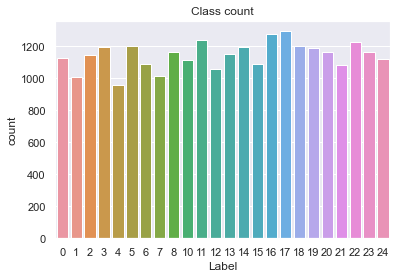

In [17]:
sns.countplot(x=labels,data=df).set(title='Class count')
plt.xlabel('Label')

The classes look balanced, each class having at least 800 examples. So I do not take further steps in balancing out the data.
Next I create the train and test dataframes by dropping the label column. I scale the pixel values from 0-1 as this can help speed up training. Note that label 9 and 25 is missing from the above plot which corresponds to the letters J and Z.
<br>

In [48]:
train=df.drop(['label'],axis=1)
test=df_test.drop(['label'],axis=1)
train=train/255
test=test/255
train.describe()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,...,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000
mean,0.570272,0.582354,0.593128,0.602143,0.612592,0.621221,0.629303,0.636626,0.642960,0.649152,...,0.553352,0.578414,0.601278,0.624021,0.635174,0.638183,0.638848,0.635163,0.631913,0.626764
std,0.162190,0.156636,0.153162,0.151354,0.145534,0.141669,0.137319,0.132008,0.128046,0.122664,...,0.250005,0.256913,0.252657,0.249837,0.249954,0.248800,0.249056,0.248230,0.249453,0.252537
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.474510,0.494118,0.509804,0.521569,0.537255,0.549020,0.556863,0.564706,0.572549,0.580392,...,0.360784,0.376471,0.403922,0.439216,0.470588,0.490196,0.501961,0.501961,0.501961,0.492157
50%,0.588235,0.600000,0.611765,0.619608,0.627451,0.635294,0.643137,0.647059,0.650980,0.654902,...,0.564706,0.635294,0.674510,0.705882,0.717647,0.721569,0.721569,0.713725,0.713725,0.713725
75%,0.682353,0.690196,0.698039,0.701961,0.709804,0.713725,0.717647,0.721569,0.725490,0.729412,...,0.768627,0.792157,0.803922,0.811765,0.815686,0.811765,0.811765,0.807843,0.800000,0.800000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The input data of the CNN must have the same dimensions as the original image, below I reshape the dataframe to an array of 28x28x1 dimensions for each image.
<br>

In [49]:
X_train=train.to_numpy().reshape(-1,28,28,1)
X_test=test.to_numpy().reshape(-1,28,28,1)

In [52]:
print(X_train.shape)
print(X_test.shape)

(27455, 28, 28, 1)
(7172, 28, 28, 1)


The dimensions look good, the first entry is the number of examples in the train and test sets. The second and third entries correspond to the pixel width adn height of each image, the last entry is the number of channels. Since the image is in grayscale there is only one channel, if the images were in color, this value would be 3 for the red, green and blue channels.

I plot one of these images below to make sure the transformation is ok.
<br>

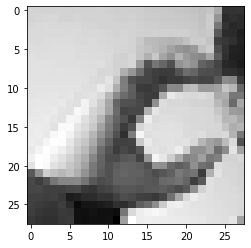

In [53]:
plt.imshow(X_train[3],cmap='gray')
plt.show()

<br>
The feature data looks fine. I now transform the labels into a 1-d vector whose dimension is equal to the number of unique labels (24) and for each example, all the entries except for one will be 0, the non-zero entry corresponds to the label number. For example, if  label=0 the vector will be [1,0,0,....,0]. This format is required to evaluate the CNN model in the end as its output will be a vector of this form.
<br>

In [ ]:
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(labels)
y_test = label_binarizer.fit_transform(testlabel)


In [38]:
y_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]])

<br>
Now that the data is in an appropriate format, I will build the CNN model. I will give a very brief overview of the different layers used and the reason for using them. 
The  'Conv2D' layer is the standard layer in CNNs, containing a specified number of matrices or kernels of shape (x,y). The kernel is multiplied across the input which will be output to the next layer after application of the activation function, I use the 'relu' activation function and 'same' for padding as I find it works better than the default 'same' setting. 

The MaxPool2D layer converts a window of size (x,y) of the input into a single value by taking the maximum value across that window, this is done to reduce the number of parameters to speed up training. 

The  'Dropout' layer randomly chooses a fraction of the output from the previou layer and sets it to 0. This is done to prevent overfitting. 

The 'BatchNormalization' layer normalizes the input before feeding into the next layer, this helps to improve the generalizability of the model and it is recommended  to add this especially in deeper layers of a neural network. 

The 'Flatten' layer converts the   input from a bunch of matrices into a 1-D list which is required before feeding into a 'Dense' layer, which is the standard layer in deep neural networks containing a specified number of neurons that are densely connected with the previous layer and these neurons apply a linear transformation and activation to the input. 

Except for the final layer of the CNN there is no pre-determined way to setup the model architecture other than combining intuition from previous works and some trial and error. The models can also be fit using a GridSearch to find which set of hyperparameters produces the better model. The last layer will be a densely connected layer with 24 neurons, corresponding to the number of classes. Its activation function will be softmax so that the output will be a vector similar to the 'y_train' and 'y_test' vectors described above.
<br>
<br>

In [ ]:
model = Sequential()
model.add(Conv2D(75 , (3,3) , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(50 , (3,3), padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(25 , (3,3) , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 24 , activation = 'softmax'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 28, 28, 75)        750       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 14, 14, 75)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 14, 14, 50)        33800     
                                                                 
 dropout_12 (Dropout)        (None, 14, 14, 50)        0         
                                                                 
 batch_normalization_17 (Bat  (None, 14, 14, 50)       200       
 chNormalization)                                                
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 7, 7, 50)        

The model summary tells us there are 263,599 parameters to train, these are a lot of parameter but the training takes place suprisingly fast!
I compile the model choosing the popular 'adam' optimizer and the categorical crossentropy for the loss function, which is commonly used in multiclass classification. The model will be evaluated based on the accuracy of its output, which is fine to use here since the classes are balanced.
<br>

In [ ]:
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

I include a model checkpoint to save the best model, in case the final model is not the best fit, this can occur due to overfitting, diverging gradients etc. I will train the model for 10 epochs in batches of 100.

In [78]:
checkpoint = ModelCheckpoint('sign_clf.hdf5', monitor='val_loss',save_best_only=True)

In [79]:
fitting = model.fit(x=X_train,y=y_train, batch_size = 100 ,epochs = 10, 
                    validation_data = (X_test, y_test), callbacks=[checkpoint])

Epoch 1/10
275/275 [==============================] - 54s 195ms/step - loss: 0.5172 - accuracy: 0.8500 - val_loss: 2.0453 - val_accuracy: 0.4470
Epoch 2/10
275/275 [==============================] - 54s 195ms/step - loss: 0.0206 - accuracy: 0.9958 - val_loss: 0.2054 - val_accuracy: 0.9435
Epoch 3/10
275/275 [==============================] - 50s 182ms/step - loss: 0.0085 - accuracy: 0.9985 - val_loss: 0.1975 - val_accuracy: 0.9399
Epoch 4/10
275/275 [==============================] - 48s 173ms/step - loss: 0.0053 - accuracy: 0.9991 - val_loss: 0.1352 - val_accuracy: 0.9532
Epoch 5/10
275/275 [==============================] - 60s 219ms/step - loss: 0.0128 - accuracy: 0.9963 - val_loss: 0.2211 - val_accuracy: 0.9283
Epoch 6/10
275/275 [==============================] - 65s 235ms/step - loss: 0.0033 - accuracy: 0.9993 - val_loss: 0.2085 - val_accuracy: 0.9522
Epoch 7/10
275/275 [==============================] - 47s 172ms/step - loss: 0.0133 - accuracy: 0.9957 - val_loss: 0.6854 - val_ac

<br>
From the output we see the final model is not the best fit for the test data, we can visual this with a plot showing the loss function and accuracy over each epoch for the train and test set.
<br>

In [2]:
def learningcurve(model_fit):
    epochs = [i for i in range(len(model_fit.history['accuracy']))]
    fig , ax = plt.subplots(1,2)
    train_acc = model_fit.history['accuracy']
    train_loss = model_fit.history['loss']
    val_acc = model_fit.history['val_accuracy']
    val_loss = model_fit.history['val_loss']
    fig.set_size_inches(16,9)

    ax[0].plot(epochs , train_acc , 'bo-' , label = 'Training Accuracy')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
    ax[0].set_title('Training & Test Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss , 'bo-' , label = 'Training Loss')
    ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
    ax[1].set_title('Training & Test Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Loss")
    plt.show()


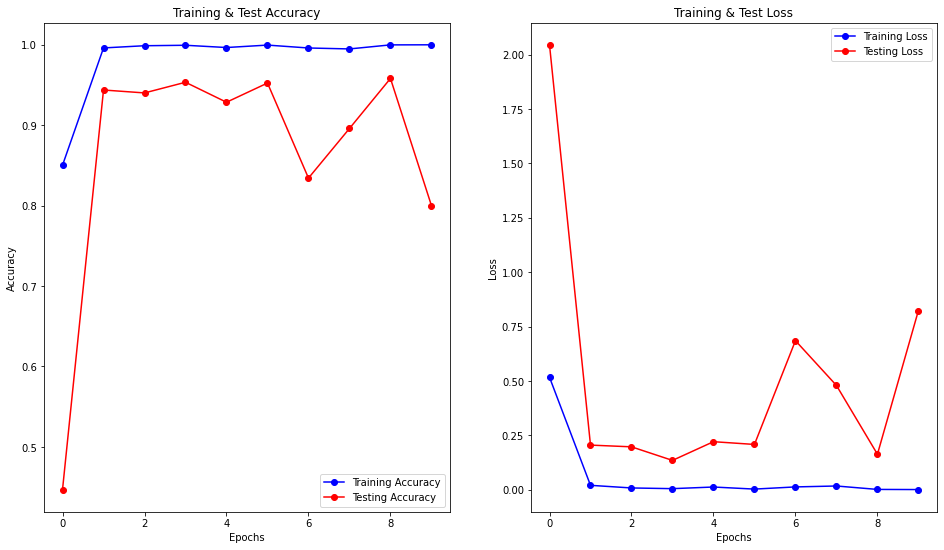

In [92]:
learningcurve(fitting)


<br>
The above plot shows that the test accuracy decreases up to around epoch 5 and then starts oscillating for proceeding epochs. A common cause of this issue is having a relatively large learning rate at later epochs which can cause the model to overshoot its minimum loss. One way to combat this is to reduce the learning rate when the model accuracy improves using <a href='https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau'> ReduceLROnPlateau </a>, this way we gradually take smaller and smaller steps against the gradient so as to avoid overshooting the minimum. I will implement this and train the model to check if it improve performance

Luckily the best model was saved using the model checkpoint, we can load this model and continue training, this saves us time since we do not have to start from an untrained model.

In [81]:
model.load_weights('sign_clf.hdf5')

In [94]:
model.evaluate(X_test,y_test)[1]

225/225 [==============================] - 3s 14ms/step - loss: 0.1352 - accuracy: 0.9532


0.9531511664390564

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, 
                                            verbose=1,factor=0.5, min_lr=0.000001)

I will now train the model with this additional callback

In [ ]:
fitting = model.fit(x=X_train,y=y_train, batch_size = 100 ,epochs = 20, 
                    validation_data = (X_test, y_test), callbacks=[checkpoint,learning_rate_reduction])

In [58]:
fitting = model.fit(x=X_train,y=y_train, batch_size = 100 ,epochs = 20, 
                    validation_data = (X_test, y_test), callbacks=[checkpoint,learning_rate_reduction])

Epoch 1/20
275/275 [==============================] - 52s 190ms/step - loss: 3.0830e-05 - accuracy: 1.0000 - val_loss: 0.1472 - val_accuracy: 0.9597 - lr: 3.1250e-05
Epoch 2/20
275/275 [==============================] - 49s 179ms/step - loss: 8.6384e-06 - accuracy: 1.0000 - val_loss: 0.1456 - val_accuracy: 0.9597 - lr: 3.1250e-05
Epoch 3/20
275/275 [==============================] - ETA: 0s - loss: 9.6197e-06 - accuracy: 1.0000
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
275/275 [==============================] - 49s 178ms/step - loss: 9.6197e-06 - accuracy: 1.0000 - val_loss: 0.1459 - val_accuracy: 0.9594 - lr: 3.1250e-05
Epoch 4/20
275/275 [==============================] - 48s 176ms/step - loss: 1.6258e-05 - accuracy: 1.0000 - val_loss: 0.1452 - val_accuracy: 0.9589 - lr: 1.5625e-05
Epoch 5/20
275/275 [==============================] - ETA: 0s - loss: 1.5361e-05 - accuracy: 1.0000
Epoch 5: ReduceLROnPlateau reducing learning rate to 7.812500371073838

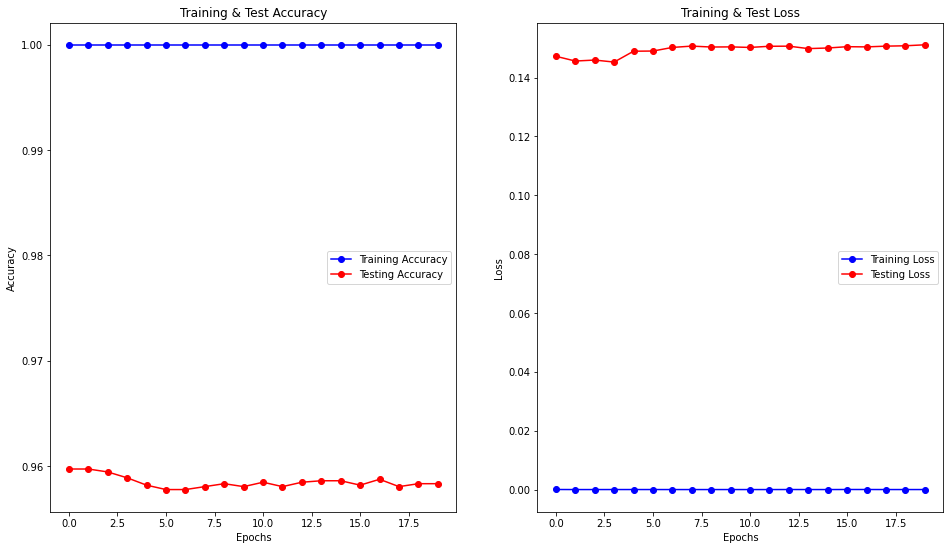

In [67]:
learningcurve(fitting)

In [60]:
model.load_weights('sign_clf.hdf5')
model.evaluate(X_test,y_test)[1]

225/225 [==============================] - 2s 10ms/step - loss: 0.1452 - accuracy: 0.9589


0.9588678479194641

Reducing the learning rate has curbed the oscillation in the testing loss and accuracy! I get a 95.9% accuracy, about 0.5% increase from before. 
Let's delve a bit deeper and see how the model performs for each class. To do this I first convert the output vector of the model to the integer label value, like how it was in the original dataframe.

In [97]:
predict_x=model.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)


In [101]:
classes_x[0:20]

array([ 6,  5,  9,  0,  3, 20,  9, 13,  3,  7,  8,  8, 20, 11,  7,  4, 21,
        0,  7,  7])

In [105]:
classes_x=np.where(classes_x>=9,classes_x+1,classes_x)

In [107]:
classes_x[0:20]

array([ 6,  5, 10,  0,  3, 21, 10, 14,  3,  7,  8,  8, 21, 12,  7,  4, 22,
        0,  7,  7])

<br>
I added a one for each value greater than or equal to 9 to account for the fact that the letter J (label 9) is omitted from the dataset.
The classification report below shows the performance across each class.
<br>

In [66]:
print(classification_report(testlabel, classes_x))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       331
           1       1.00      1.00      1.00       432
           2       1.00      1.00      1.00       310
           3       1.00      1.00      1.00       245
           4       1.00      1.00      1.00       498
           5       0.95      1.00      0.97       247
           6       0.88      0.89      0.89       348
           7       0.95      0.91      0.93       436
           8       0.96      0.95      0.96       288
          10       0.98      1.00      0.99       331
          11       0.94      1.00      0.97       209
          12       0.97      0.98      0.97       394
          13       0.96      0.84      0.90       291
          14       1.00      1.00      1.00       246
          15       0.95      1.00      0.97       347
          16       1.00      1.00      1.00       164
          17       0.80      0.85      0.83       144
          18       1.00    

We see that a few classes e.g., 17 and 19, corresponding to letters R and T seem to performs the worst.

### Future improvements

As we saw above, few classes perform poorer than the rest, one way to improve the model is by increasing the number of samples for these class, we can do this without the need for obtaining new images by augmenting existing images, in fact we can do this for the whole training set to provide more examples for the model to train on. 
